In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


255 213
897 0


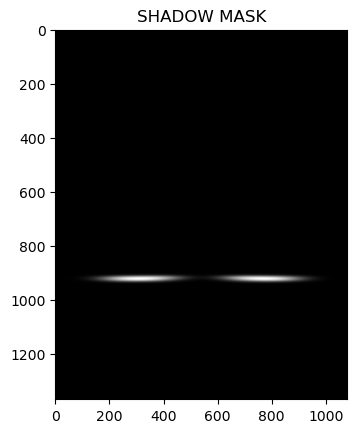

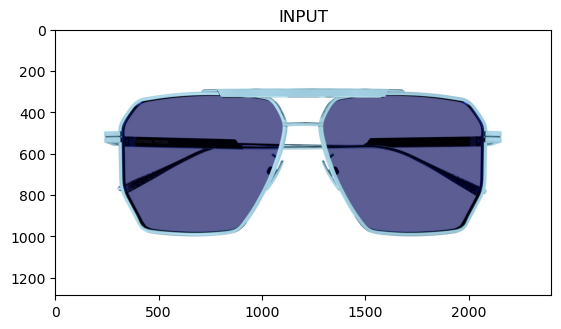

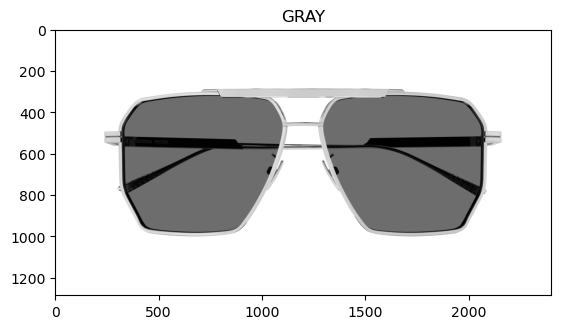

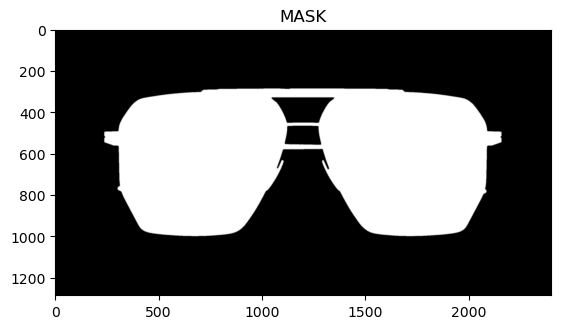

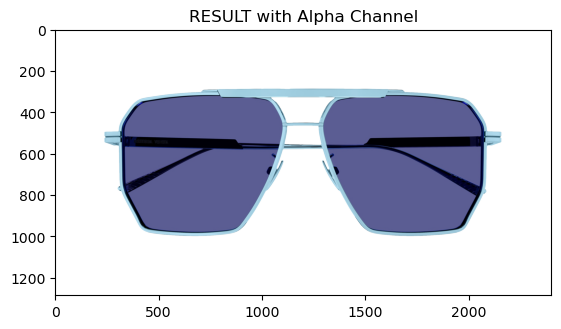

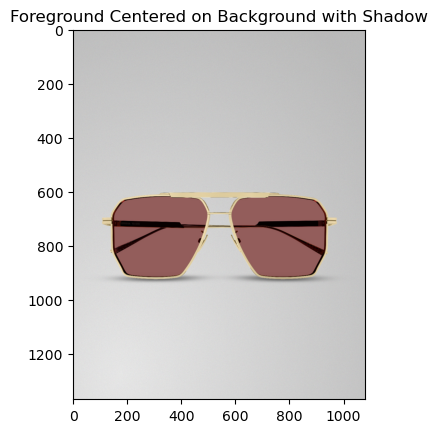

<Figure size 640x480 with 0 Axes>

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# load image
img = cv2.imread('image.jpg')

# convert to graky
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
# use borderconstant of black since foreground touches the edges
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# Load the background image
bg_img = cv2.imread('bg.jpg')

# Get dimensions of the foreground and background images
fg_h, fg_w, _ = result.shape
bg_h, bg_w, _ = bg_img.shape

# Resize foreground image to match background width while maintaining aspect ratio
aspect_ratio = fg_w / fg_h
new_fg_w = bg_w
new_fg_h = int(new_fg_w / aspect_ratio)
result_resized = cv2.resize(result, (new_fg_w, new_fg_h))

# Update foreground dimensions after resizing
fg_h, fg_w, _ = result_resized.shape

# Calculate the position to center the foreground image
center_x = int((bg_w - fg_w) / 2)
center_y = int((bg_h - fg_h) / 2) + (int(bg_h /17))


# Ensure the foreground image fits within the background image
if center_x < 0 or center_y < 0 or center_x + fg_w > bg_w or center_y + fg_h > bg_h:
    print("Resized foreground image is still larger than the background image or centering is not possible.")
    # You might want to handle this case differently
else:
    # Create a region of interest in the background image for the foreground and shadow
    roi = bg_img[center_y:center_y + fg_h, center_x:center_x + fg_w].copy()

    # Convert foreground and ROI to float32 for alpha blending
    fg_float = result_resized.astype(np.float32)
    roi_float = roi.astype(np.float32)

    # Extract alpha channel from foreground
    alpha = fg_float[:, :, 3] / 255.0
    alpha_3_channel = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR) # Convert alpha to 3 channels

    # Blend the foreground and ROI
    blended_fg = roi_float * (1 - alpha_3_channel) + fg_float[:,:,:3] * alpha_3_channel

    # --- Add shadow ---
    # Create a shadow mask from the resized foreground's alpha channel
    shadow_mask = result_resized[:,:,3]


    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(fg_h / 5),int( fg_h / 5)))


    #shrink the shadow
    shadow_mask = cv2.erode(shadow_mask, erode_kernel)

    # Blur the shadow mask
    shadow_mask = cv2.GaussianBlur(shadow_mask, (0,0), sigmaX=fg_h / 10, sigmaY=fg_h / 10)
    # Get bounding box of actual alpha content
    non_zero_coords = cv2.findNonZero(result_resized[:, :, 3])
    x, y, w, h = cv2.boundingRect(non_zero_coords)

    # get the difference between real height and image height
    dif_h = fg_h - h
    dif_w = fg_w - w

    print(dif_h, dif_w)

    # Generate original blurred shadow (like before)
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(fg_h / 5), int(fg_h / 5)))
    shadow_mask_raw = cv2.erode(result_resized[:, :, 3], erode_kernel)
    shadow_mask_blurred = cv2.GaussianBlur(shadow_mask_raw, (0, 0), sigmaX=fg_h / 10, sigmaY=fg_h / 10)

    # Resize shadow to full foreground width, with enough height to hold full blur
    shadow_height = 50
    shadow_mask_resized = cv2.resize(shadow_mask_blurred, (fg_w, shadow_height))

    # Create full-size background mask
    shadow_mask = np.zeros((bg_h, bg_w), dtype=np.uint8)

    # Position the shadow just under the bottom of the foreground content
    shadow_top =int( center_y + y + h -  ((shadow_height/3)+shadow_height*((dif_h/2)/fg_h)))
    shadow_left = center_x

    print(shadow_top, shadow_left)

    # Ensure shadow fits within background
    if shadow_top + shadow_height <= bg_h:
        shadow_mask[shadow_top:shadow_top + shadow_height, shadow_left:shadow_left + fg_w] = shadow_mask_resized
    else:
        print("Shadow would go out of bounds.")


    plt.imshow(shadow_mask, cmap='gray')
    plt.title("SHADOW MASK")
    plt.figure()



    shadow_alpha = shadow_mask.astype(np.float32) / 255.0
    shadow_alpha_3_channel = cv2.cvtColor(shadow_alpha, cv2.COLOR_GRAY2BGR)

    # Define shadow color and opacity
    shadow_color = (0, 0, 0) # Black shadow
    shadow_opacity = 0.6

    # Step 1: Create full-sized black shadow layer
    shadow_layer_full = np.full_like(bg_img, shadow_color, dtype=np.float32)

    # Convert background to float32 for blending
    bg_img = bg_img.astype(np.float32)

    # Step 2: Blend shadow FIRST
    bg_img = bg_img * (1 - shadow_alpha_3_channel * shadow_opacity) + shadow_layer_full * shadow_alpha_3_channel * shadow_opacity



    # Step 3: Blend foreground onto background (preserving shadow through transparency)
    bg_roi = bg_img[center_y:center_y + fg_h, center_x:center_x + fg_w]

    # Re-use alpha from earlier
    blended_fg_alpha = alpha_3_channel

    # Blend using alpha channel: new_pixel = fg * alpha + bg * (1 - alpha)
    fg_over_bg = blended_fg * blended_fg_alpha + bg_roi * (1 - blended_fg_alpha)

    # Place blended result back
    bg_img[center_y:center_y + fg_h, center_x:center_x + fg_w] = fg_over_bg


    # Step 2.5: Darken the foreground object where shadow mask overlaps

    # Scale down shadow alpha to control darkness amount
    shadow_alpha_foreground = shadow_alpha * 0.25  # adjust darkness strength

    # Extract shadow mask for foreground region
    shadow_overlay_region = shadow_alpha_foreground[center_y:center_y + fg_h, center_x:center_x + fg_w]

    # Foreground alpha mask (normalized 0-1)
    foreground_alpha_mask = alpha

    # Combine masks to apply darkness only where both shadow and foreground exist
    darken_mask = (shadow_overlay_region * foreground_alpha_mask).astype(np.float32)

    # Convert to 3 channels
    darken_mask_3ch = cv2.cvtColor(darken_mask, cv2.COLOR_GRAY2BGR)

    # Darken foreground colors by multiplying by (1 - darken_mask * darkness_strength)
    darkness_strength = 0.5  # 0=no darkening, 1=fully black

    fg_float_rgb = fg_float[:, :, :3]

    # Apply darkening
    fg_float_rgb_darkened = fg_float_rgb * (1 - darken_mask_3ch * darkness_strength)

    # Put darkened RGB back
    fg_float[:, :, :3] = fg_float_rgb_darkened

    # Then blend fg_float onto bg_img as usual
    bg_roi = bg_img[center_y:center_y + fg_h, center_x:center_x + fg_w]

    fg_over_bg = bg_roi * (1 - alpha_3_channel) + fg_float[:, :, :3] * alpha_3_channel

    bg_img[center_y:center_y + fg_h, center_x:center_x + fg_w] = fg_over_bg



    # Final result to uint8
    bg_img = bg_img.astype(np.uint8)



    # --- End Add shadow ---


# display result, though it won't show transparency
plt.imshow(img)
plt.title("INPUT")
plt.figure()

plt.imshow(gray, cmap='gray')
plt.title("GRAY")
plt.figure()

plt.imshow(mask, cmap='gray')
plt.title("MASK")
plt.figure()

plt.imshow(result)
plt.title("RESULT with Alpha Channel")
plt.figure()

# Display the composite image
if center_x >= 0 and center_y >= 0 and center_x + fg_w <= bg_w and center_y + fg_h <= bg_h:
    plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
    plt.title("Foreground Centered on Background with Shadow")
    plt.figure()
    cv2.imwrite('output_image_with_shadow.webp', bg_img, [cv2.IMWRITE_WEBP_QUALITY, 100])
else:
    print("Resized foreground image is still larger than the background image or centering is not possible.")

plt.show()